# Sentence Mapper

In [1]:
%load_ext autoreload
%autoreload 2

import logging

from rich import print
from datasets import load_dataset

from src.pipeline import SentenceMapperPipeline
from src.visualization import SentenceMapperVisualizer
from src.powerlaw_optimizer import fit_frontier_curve
from src.sentence_processor import SentenceProcessor
from src.map_reduce_summarizer import MapReduceSummarizer

# Suppress langchain text splitter warnings
logging.getLogger('langchain_text_splitters.base').setLevel(logging.ERROR)


## Get Some Data

For this example, we will use one report from the **GovReports dataset**, which is a long document summarization dataset, with about 19.5k reports published by the U.S. Government Accountability Office (GAO) and Congressional Research Service (CRS).

They cover researches on a broad range of national policy issues, including health care, education, national security, economics, and the environment.


Reference: https://arxiv.org/pdf/2104.02112

## Multi-LexSum

Is a collection of 9,280 such legal case summaries. It presents a challenging multi-document summarization task given the long length of the source documents, often exceeding two hundred pages per case. Experts—lawyers and law students—are trained to follow carefully created guidelines, and their work is reviewed by an additional expert to ensure quality.

Reference: Shen et al. 2022 https://arxiv.org/pdf/2206.10883

In [48]:
# Download one sample from the train split.

govreport = load_dataset("ccdv/govreport-summarization", split="train[:10]")
print(govreport[0]["report"][:500])


#multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20230518")

# Download multi_lexsum locally and load it as a Dataset object 

#example["sources"] # A list of source document text for the case

The structure of the armed forces is based on the Total Force concept, which recognizes that all elements of the 
structure—active duty military personnel, reservists, defense contractors, host nation military and civilian 
personnel, and DOD federal civilian employees—contribute to national defense. In recent years, federal civilian 
personnel have deployed along with military personnel to participate in Operations Joint Endeavor, conducted in the
countries of Bosnia-Herzegovina, Croatia, and Hung

## Sentence Processor

The SentenceProcessor is a class used to chunk the document, extract the sentences and calculate the similarity between sentences and their parent chunk. 

It requires 2 parameters: 

- chunk_size: int = 2048 
   - Character lenght of the chunks. Should be similar to the context window of the embedding model. 
- min_sentence_lenght: int = 256
   - Character lenght for sentences.
 

SentenceProcessor uses model2vec to get chunk and sentence embeddings super fast. 

It uses chonkie as its default splitter.  However, some domains may use specific abbreviations or prefixes that can confuse the sentence splitter. These prefixes can be passed in custom_parameters, so they are do not end sentences.


For the GovReports dataset, we can add some common abbreviations:
- **U.S.** (United States)
- **H.R.** (House Resolution)
- **H.Rept.** (House Report)
- **P.L.** (Public Law)
- **S.** (Senate bill)

In [3]:
custom_parameters = {
    "prefixes": [
        "H.R", "H.Rept", "S", "P.L", "Rep", "Sen", "S.Rept",
        "U.S", "N.Y", "Calif", "U.N"
    ],
    "additional_replacements": {
        "U.": "U<prd>",
        "S.": "S<prd>",
        "U.S.": "U<prd>S<prd>",
        "U.S.A.": "U<prd>S<prd>A<prd>",
        "i.e.": "i<prd>e<prd>",
        "e.g.": "e<prd>g<prd>",
        "Ph.D.": "Ph<prd>D<prd>",
        "et al.": "et<prd>al<prd>",
    }
}

# Initialize processor with custom splitter for government reports
processor = SentenceProcessor(
    embedding_model_name="minishlab/potion-base-8M",
    chunk_size=2048,
    min_sentence_length=128,
    custom_parameters=custom_parameters
)


In [77]:
report = govreport[1]["report"]
reference_summary = govreport[1]["summary"]

features = processor.compute_document_features(text=report)

print(f"Total chunks: {len(features['chunks'])}")
print(f"Total sentences: {len(features['all_similarities'])}")
print(f"Total tokens: {features['total_tokens']}")

Total chunks: 28

Total sentences: 330

Total tokens: 10015

## The Frontier Curve

The similarity between a sentence and its parent chunk naturally increases as there is more word overlap. As a sentence contains more of the chunk's words, it naturally becomes more similar through pure overlap, not necessarily through information density. 

If a sentence is more similar to its parent chunk than what is expected from the overlap, then that sentece must contain information that is more relevant to the sorounding text. 

This is the main idea of SentenceMapper:

- Plot the similarity vs. lenght ratio in a log-log space. 
- Identify sentences at the upper frontier and fit a linear relationship.

The function fit_frontier_curve, fits this relationship. 

Then the residual (distance to the frontier curve), should tell us which sentence is more representative. 

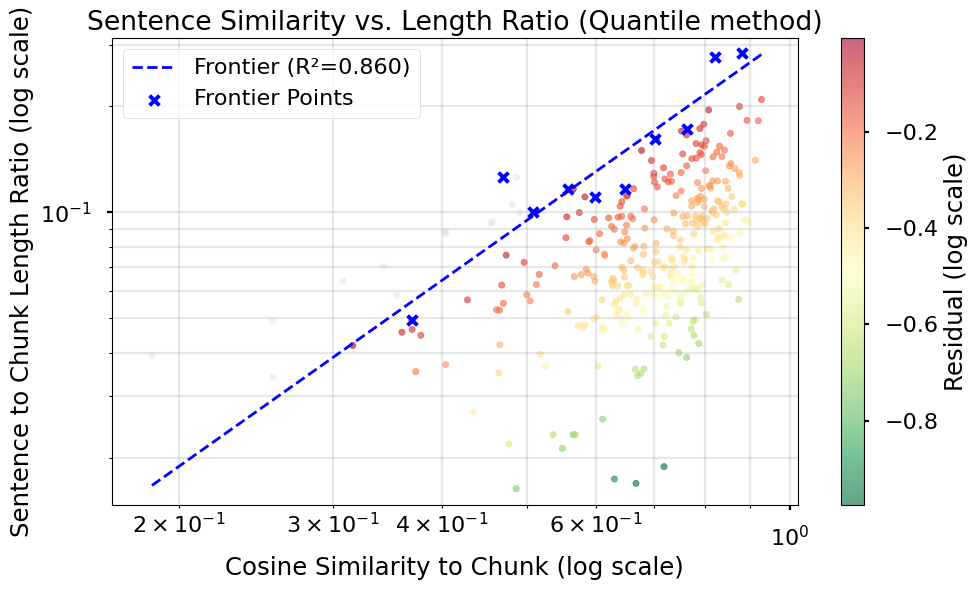

In [69]:
slope, intercept, info = fit_frontier_curve(
    features['all_similarities'],
    features['ratios'],
    # quantile=0.95,
    n_bins=20,
    method='binned_max'
)

visualizer = SentenceMapperVisualizer(
    slope=slope,
    initial_intercept=intercept
)

visualizer.plot_with_frontier(
    similarities=features['all_similarities'],
    ratios=features['ratios'],
    slope=slope,
    intercept=intercept,
    info=info,
    title=f"Sentence Similarity vs. Length Ratio (Quantile method)",
)

## Filter the best sentences

SentenceMapperPipeline ties all together. Use the function process_document to get the best sentences.

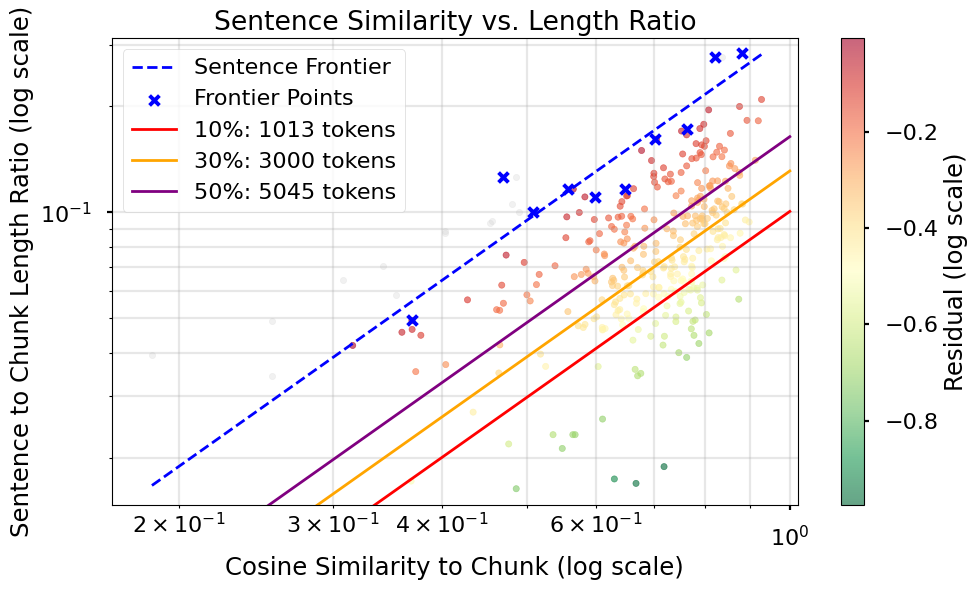

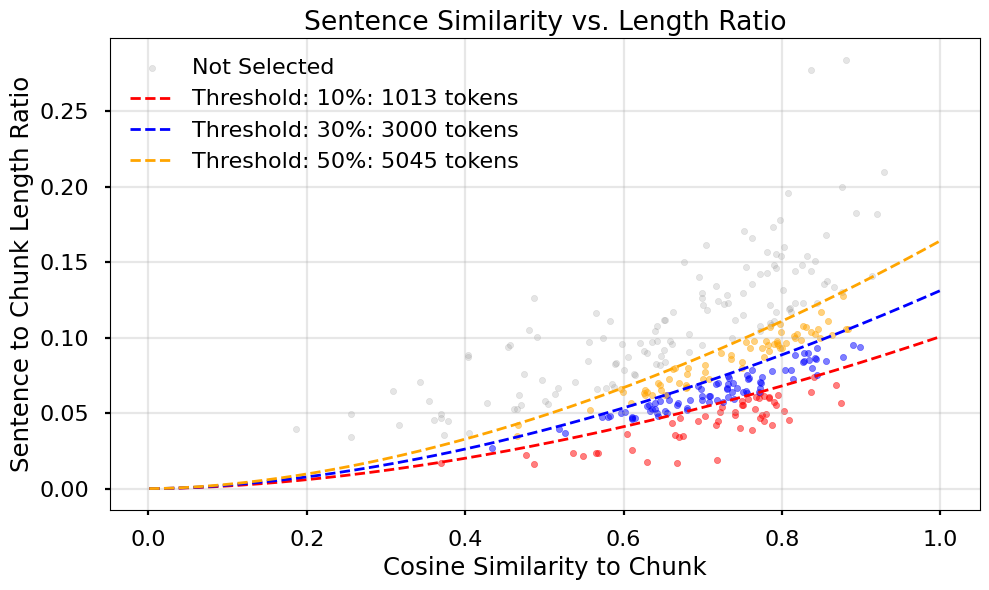

In [98]:
# Initialize pipeline with custom splitter
pipeline = SentenceMapperPipeline(
    embedding_model_name="minishlab/potion-base-8M",
    chunk_size=2048,
    min_sentence_length=124,
    custom_parameters=custom_parameters,    
)

objective_percentages = [0.1, 0.3, 0.5]

results = []
for objective_percentage in objective_percentages:
    result = pipeline.process_document(
        text=report,
        objective_percentage=objective_percentage,
        fit_method='binned_max'
    )
    results.append(result)

result = results[1]  # Select the result for 30% objective
visualizer.plot_with_frontier(
    similarities=result['all_similarities'],
    ratios=result['ratios'],
    slope=slope,
    intercept=intercept,
    info=info,
    x_opt=[r['x_opt'] for r in results],
    labels=[f"{objective_percentage*100:.0f}%: {result['selected_tokens']} tokens" for objective_percentage, result in zip(objective_percentages, results)],
    title=f"Sentence Similarity vs. Length Ratio",
    save_path="frontier_with_selection.png",
)

visualizer.plot_similarity_vs_ratio(
    similarities=result['all_similarities'],
    ratios=result['ratios'],
    mask = [r['mask'] for r in results],
    x_opt= [r['x_opt'] for r in results],
    labels=[f"{objective_percentage*100:.0f}%: {r['selected_tokens']} tokens" for objective_percentage, r in zip(objective_percentages, results)],
    title="Sentence Similarity vs. Length Ratio",
)

In [83]:
print("Document total tokens:", sum(result['tokens']))
print(f"Selected tokens: {result['selected_tokens']}")
print(f"Compression ratio: {result['selected_tokens']/sum(result['tokens']):.2%}")


Document total tokens: 10015

Selected tokens: 4015

Compression ratio: 40.09%

See the selected sentences highlighted in the HTML file.

In [84]:
visualizer.export_highlighted_text(
    sentences=result['sentences'],
    mask=result['mask'],
    output_path=f"data/html/train_2_{objective_percentage*100:.0f}.html"
)

In [85]:
# Display the first 3 chunks with highlighted sentences
visualizer.display_highlighted_text(
    sentences=result['sentences'],
    mask=result['mask'],
    title=f"Selected Sentences ({objective_percentage*100:.0f}% compression)",
    max_chunks=3,  # Limit to first 3 chunks for readability
    dark_mode=True
)

In [86]:
fig = visualizer.plot_with_frontier_interactive(
    similarities=result['all_similarities'],
    ratios=result['ratios'],
    slope=slope,
    intercept=intercept,
    info=info,
    sentences=result['all_sentences'],  # Use flattened list of sentence texts
    x_opt=[result['x_opt']],  # Optional threshold curves
    labels=["40%"],  # Optional labels
    save_path="output.html",  # Saves as interactive HTML
)


## Map - Reduce Summarization

Traditional map-reduce is token expensive. Summarizing section into intermediate summaries (map step), and then generating the final summary is expensive.

After extracting the most information-dense sentences, we can pass them to a LLM to generate a summary spanning the whole document. 
LLM's nowadays are intelligent enough to understand the document even with 70-80% missing context. 


In [87]:
summarizer = MapReduceSummarizer(
    summarize_model="gpt-4o",
    judge_model="gpt-4.1"
)

In [88]:
llm_summary = summarizer.summarize_with_llm(text=result["selected_text"])

In [89]:
# Compare with the human reference summary

print("\n[bold]Generated Summary:[/bold]\n")
print(llm_summary)
print("\n[bold]Reference Summary:[/bold]\n")
print(reference_summary)

Generated Summary:

The taxation system in the United States involves complex interplay between corporate and individual income taxes, 
each depending on a business's legal structure and the source of income. Generally, corporate income, including net
profits from operations and income from interest, dividends, and capital gains, is taxed at federal rates ranging 
from 15% to 35%, with worldwide income of domestic corporations subject to U.S. taxation and eligible for foreign 
tax credits. Individuals are taxed on business-source income, including dividends and capital gains, with rates 
from 10% to 35%, while certain types of income, such as long-term capital gains, may bear lower rates. Both systems
aim to balance tax revenues with policy goals, though they often result in inefficiencies and costs beyond direct 
payments to the Treasury.

Businesses are a significant source of federal revenue, paying substantial corporate taxes and collecting other 
federal taxes. In 2005, corporate businesses directly contributed $278 billion in corporate income tax. However, 
the design of the current tax system is widely criticized for its complexity and inefficiency, leading to economic 
distortions and implications for U.S. competitiveness. Tax preferences, or expenditures, act like federal spending 
programs, narrowing the tax base by necessitating higher rates elsewhere. Furthermore, the system impedes decisions
regarding investments by favoring debt over equity financing due to differing tax treatments, and complications 
arise with corporate tax avoidance, such as transfer pricing ambiguities.

Reform proposals for the U.S. tax system suggest transitioning towards broad-based tax systems with minimal 
exceptions, as these are more efficient and promote a level playing field, ultimately enhancing economic 
performance and living standards. A broad tax base, combined with lower rates, minimizes efficiency costs and could
yield necessary revenues while reducing compliance burdens. Additionally, simplifying tax codes could improve 
voluntary compliance rates.

Various alternatives to the traditional income tax system have been proposed, including consumption taxes like 
national retail sales taxes (RST) and value-added taxes (VAT), which target consumption rather than income. The 
Hall-Rabushka flat tax model combines elements of income and consumption taxes, allowing deductions for wages and 
retirement income at the business level before taxing these at the individual level. While these proposals suggest 
significant changes in how taxes are levied, the shift towards consumption-based systems could influence tax 
compliance, administration, and possibly U.S. trade balance.

Lastly, transitioning to a new tax system must address issues like maintaining tax credits and ensuring revenue 
neutrality, which could involve increasing tax rates temporarily. Policymakers are guided by principles aimed at 
developing a tax policy that is both efficient and responsive to future fiscal necessities, potentially informed by
studies like "Understanding the Tax Reform Debate" and recommendations from advisory panels on federal tax reform.

Reference Summary:

Business income taxes, both corporate and noncorporate, are a significant portion of federal tax revenue. 
Businesses also play a crucial role in collecting taxes from individuals, through withholding and information 
reporting. However, the design of the current system of business taxation is widely seen as flawed. It distorts 
investment decisions, hurting the performance of the economy. Its complexity imposes planning and record keeping 
costs, facilitates tax shelters, and provides potential cover for those who want to cheat. Not surprisingly, 
business tax reform is part of the debate about overall tax reform. The debate is occurring at a time when 
long-range projections show that, without a policy change, the gap between spending and revenues will widen. This 
testimony reviews the nation's long term fiscal imbalance and what is wrong with the current system of business 
taxation and provides some principles that ought to guide the debate about business tax reform. This statement is 
based on previously published GAO work and reviews of relevant literature. The size of business tax revenues makes 
them very relevant to any plan for addressing the nation's long-term fiscal imbalance. Reexamining both federal 
spending and revenues, including business tax policy and compliance must be part of a multipronged approach to 
address the imbalance. Some features of current business taxes channel investments into tax-favored activities and 
away from more productive activities and, thereby, reduce the economic well-being of all Americans. Complexity in 
business tax laws imposes costs of its own, facilitates tax shelters, and provides potential cover for those who 
want to cheat. IRS's latest estimates show a business tax gap of at least $141 billion for 2001. This in turn 
undermines confidence in the fairness of our tax system--citizens' confidence that their friends, neighbors, and 
business competitors pay their fair share of taxes. Principles that should guide the business tax reform debate 
include: (1) The proposed system should raise sufficient revenue over time to fund our current and future expected 
expenditures. (2) The tax base should be as broad as possible, which helps to minimize overall tax rates. (3) The 
proposed system should improve compliance rates by reducing tax preferences and complexity and increasing 
transparency. (4) To the extent other goals, such as equity and simplicity, allow, the tax system should aim for 
neutrality by not favoring some business activities over others. More neutral tax policy has the potential to 
enhance economic growth, increase productivity and improve the competitiveness of the U.S. economy in terms of 
standard of living. (5) The consideration of transition rules must be an integral part of any reform proposal.

In [90]:
from src.map_reduce_summarizer import calculate_rouge_scores

print(f"Input length: {len(report)} characters")
print(f"Extracted sentences lenght: {len(result["selected_text"])}")
print(f"Reference summary length: {len(reference_summary)} characters")
print(f"Generated summary lenght: {len(llm_summary)}")

rouge_scores = calculate_rouge_scores(reference_summary, llm_summary)

print(f"  ROUGE-1 F1: {rouge_scores['rouge1']:.4f}")
print(f"  ROUGE-2 F1: {rouge_scores['rouge2']:.4f}")
print(f"  ROUGE-L F1: {rouge_scores['rougeL']:.4f}")


Input length: 53535 characters

Extracted sentences lenght: 20736

Reference summary length: 2791 characters

Generated summary lenght: 3132

ROUGE-1 F1: 0.4685

ROUGE-2 F1: 0.0880

ROUGE-L F1: 0.1734

## LLM-Judge and Future Work

We can use a LLM-as-a-Judge to identify the most salient differences.

In the future, SentenceMapper will support the use of a "semantic-bias". A list of keywords or keyphrases that
are relevant for the dataset. They should increase the likelihood of sentences containing them to be extracted.

The LLM-as-a-Judge model can also suggest guidelines for the summarizer.
This infomation can be used to improve the summarization prompt.

Evaluate a small sample of summaries of the dataset, to get a representative list of both, keywords and guideance. Implementing both strategies should improve the quality of the summaries.

In [91]:
judge_evaluation = summarizer.judge_with_llm(
        generated_summary=llm_summary, 
        reference_summary=reference_summary,
        compression_ratio=40,
    )

print(judge_evaluation["differences"])
print(judge_evaluation["semantic_bias"])
print(judge_evaluation["high-level guidance"])
print(judge_evaluation["overall_score"])

The generated summary emphasizes the technical mechanics of U.S. business and individual income taxation, 
specifying rates, structures, and types of income, as well as detailing alternative tax proposals (e.g., 
consumption taxes, flat tax models). In contrast, the reference summary focuses more on the rationale behind the 
call for business tax reform, the economic distortions caused by complexity and preferential treatment, fiscal 
imbalance concerns, compliance issues, and a set of guiding principles for reform. The reference summary discusses 
the role of business taxes in long-term fiscal planning, the need for neutrality, simplicity, revenue sufficiency, 
compliance, and transition rules—several of which are either missing or underemphasized in the generated summary. 
The generated summary also includes more concrete recent figures (e.g., $278 billion in 2005 revenues) and more 
technical detail about specific reform models, but does not summarize the core principles for reform as succinctly 
and explicitly as the reference.

[
    'fiscal imbalance',
    'tax reform principles',
    'tax neutrality',
    'compliance',
    'complexity',
    'economic distortions',
    'transition rules',
    'tax base broadening',
    'revenue sufficiency',
    'equity'
]

Summaries should balance technical exposition of tax mechanics with discussion of policy rationale, economic 
impact, and reform principles. Clearly articulate why the issues matter, highlight intended policy outcomes, and 
contextualize recommendations with respect to long-term fiscal challenges and system fairness. When synthesizing, 
strive to capture both the operational description and the underlying motivators, such as equity, neutrality, 
compliance, and simplicity, that typically guide U.S. policy discussions.

7

In [92]:
print(llm_summary)

The taxation system in the United States involves complex interplay between corporate and individual income taxes, 
each depending on a business's legal structure and the source of income. Generally, corporate income, including net
profits from operations and income from interest, dividends, and capital gains, is taxed at federal rates ranging 
from 15% to 35%, with worldwide income of domestic corporations subject to U.S. taxation and eligible for foreign 
tax credits. Individuals are taxed on business-source income, including dividends and capital gains, with rates 
from 10% to 35%, while certain types of income, such as long-term capital gains, may bear lower rates. Both systems
aim to balance tax revenues with policy goals, though they often result in inefficiencies and costs beyond direct 
payments to the Treasury.

Businesses are a significant source of federal revenue, paying substantial corporate taxes and collecting other 
federal taxes. In 2005, corporate businesses directly contributed $278 billion in corporate income tax. However, 
the design of the current tax system is widely criticized for its complexity and inefficiency, leading to economic 
distortions and implications for U.S. competitiveness. Tax preferences, or expenditures, act like federal spending 
programs, narrowing the tax base by necessitating higher rates elsewhere. Furthermore, the system impedes decisions
regarding investments by favoring debt over equity financing due to differing tax treatments, and complications 
arise with corporate tax avoidance, such as transfer pricing ambiguities.

Reform proposals for the U.S. tax system suggest transitioning towards broad-based tax systems with minimal 
exceptions, as these are more efficient and promote a level playing field, ultimately enhancing economic 
performance and living standards. A broad tax base, combined with lower rates, minimizes efficiency costs and could
yield necessary revenues while reducing compliance burdens. Additionally, simplifying tax codes could improve 
voluntary compliance rates.

Various alternatives to the traditional income tax system have been proposed, including consumption taxes like 
national retail sales taxes (RST) and value-added taxes (VAT), which target consumption rather than income. The 
Hall-Rabushka flat tax model combines elements of income and consumption taxes, allowing deductions for wages and 
retirement income at the business level before taxing these at the individual level. While these proposals suggest 
significant changes in how taxes are levied, the shift towards consumption-based systems could influence tax 
compliance, administration, and possibly U.S. trade balance.

Lastly, transitioning to a new tax system must address issues like maintaining tax credits and ensuring revenue 
neutrality, which could involve increasing tax rates temporarily. Policymakers are guided by principles aimed at 
developing a tax policy that is both efficient and responsive to future fiscal necessities, potentially informed by
studies like "Understanding the Tax Reform Debate" and recommendations from advisory panels on federal tax reform.